# TP2 Prévision de consommation avec réseau de neurones


<img src="pictures/Présentation_FormationIA_TPDeepLearning.png" width=1000 height=60>

**Dans l'épisode précédent**  

Nos modèles de régression par décomposition saisonnière du TP1 avec la librairie Prophet nous ont donné des premiers résultats et des premières intuitions sur notre problème de prévision de consommation pour le lendemain. 

Nous avons pu analyser des profils de courbe de consommation au jour, à la semaine, au mois. Nous avons également observé la dépendance entre la consommation et la consommation retardée. Nous avons aussi vu l'impact des jours fériés. En intégrant ces différents facteurs nous sommes arrivés à une erreur moyenne de test de 4,1%.

Nous avons ensuite utilisé de premiers modèles en machine learning pour apprendre par observations l'influence de différents contextes sur la consommation sans les décrires explicitement selon des lois. 
Des difficultés se sont posées pour intégrer les variables météorologiques très dépendantes entre elles et pour intégrer un vecteur de consommation retardée.

Avec l'approche classique exposée dans ce TP1, nous avons en particulier constaté le besoin d'une expertise et d'un travail autour des variables explicatives pour obtenir un modèle performant.



**Aujourd'hui** 

Nous allons de nouveau nous attaquer à ce sujet de la prévision de consommation nationale pour le lendemain, mais cette fois en utilisant un modèle de prévision par réseau de neurones. Nous allons exploiter leur capacité à capter ces phénomènes non-linéaires et interdépendants. Nous allons mettre en évidence le moindre besoin en feature engineering en travaillant directement à la granularité de la donnée,sans créer de variables agrégées ou transformées par de l'expertise.

**Ce que vous allez voir dans ce second TP**

- Un rappel de notre problème et récapitulatif des performances de nos modèles précédents
- Une nouvelle méthode numérique pour préparer ses données et faciliter l'apprentissage: la normalisation
- La création d'un premier réseau de neurones pour prédire la consommation dans 24h
- L'utilisation de tensorboard pour observer en temps réel la courbe d'apprentissage du réseau de neurones
- La création de modèles de plus en plus performants en intégrant davantage d'informations dans notre modélisation
- L'évaluation des modèles sur 2 types de jeux de test

__NB__ : Pour ce TP nous utiliserons Keras, une bibliothèque python de haut niveau qui appelle des fonctions de la librairie TensorFlow. D'autres librairies existent, Keras a été retenue en raison de sa facilité d'utilisation.

# Dimensionnement en temps
La durée estimée de ce TP est d'environ 1h30 :
- 10-20 minutes pour charger et préparer les données pour les réseaux de neurones 
- 10-20 minutes pour entrainer un premier modèle de réseau de neurones, en examiner le code implémentant ce réseau de neurones
- Le reste pour jouer et tenter d'améliorer la qualité de la prédiction avec de nouvelles variables explicatives, ou en choisissant d'autres hyper-paramètres. 

# I) Préparation des données

In [1]:
#%autosave 0
import sys
print(sys.path)

['', '/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '/home/marotant/.local/lib/python3.6/site-packages', '/usr/lib64/python3.6/site-packages', '/usr/lib/python3.6/site-packages', '/home/marotant/.local/lib/python3.6/site-packages/IPython/extensions', '/home/marotant/.ipython']


## Chargement des librairies nécessaires

In [2]:
import os
import numpy as np
import pandas as pd
import random
import datetime
from IPython.display import SVG

import plotly
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# sklearn est la librairie de machine learning en python et scipy une librairie statistiques
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import stats

#######
# Keras est la librairie que nous utilisons pour se créer des modèles de réseau de neurones
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils import plot_model
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.callbacks import TensorBoard
from time import time

import zipfile


K.set_image_data_format('channels_last')

%matplotlib inline

Using TensorFlow backend.


## Localisation des données

In [3]:
## Choix du répertoire de travail "data_folder" dans lequel toutes les fichiers csv seront entreposés

# a actualiser avec le repertoire par defaut sur le serveur
data_folder = os.path.join(os.getcwd(),"data")

### Petite vérification
print("Mon repertoire est : {}".format(data_folder))
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Mon repertoire est : /home/marotant/TP_Formation_Conso_DeepLearning/data
Fichiers contenus dans ce répertoire :
 - Xinput.zip
 - Xinput_old.zip
 - .~lock.Xinput.csv#
 - Yconso.csv


## I) Récupération et préparation des données

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python. Les données de base à récupérer sont :
- la base de données issues du TP1 (Les historiques de consommation, leur lag, les données météo en température, leur lag, les jours feriés) 

En terme de transformation des données pour mieux les préparer:

- nous allons aussi voir comment normaliser les données, une transformation souvent bien utile en pratique pour une meilleure convergence numérique. 

Cela vient compléter les transformations vu précédemment pour les données calendaires, et aussi la transformation "one-hot" pour les données catégorielles

### Récupération de nos variables explicatives XInput

#### Les données d'entrée sont encryptées.

En effet les données météo sont confidentielles. Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE


In [4]:
password=None#

In [5]:
Xinput_zip = os.path.join(data_folder, "Xinput.zip")
zfXinput = zipfile.ZipFile(Xinput_zip)#.extractall(pwd=bytes(password,'utf-8'))
zfXinput.setpassword(bytes(password,'utf-8'))
Xinput = pd.read_csv(zfXinput.open('Xinput.csv'),sep=",",engine='c',header=0)

Xinput['ds']=pd.to_datetime(Xinput['ds'])

#Xinput = Xinput.drop(['Unnamed: 0'], axis=1)
print(Xinput.shape)

print("voici toutes les variables explicatives que l'on peut utiliser")
Xinput.columns.get_values()


(39043, 205)
voici toutes les variables explicatives que l'on peut utiliser


array(['ds', 'weekday', 'lag1D', 'lag1W', '002Th_real', '005Th_real',
       '015Th_real', '027Th_real', '070Th_real', '110Th_real',
       '120Th_real', '130Th_real', '145Th_real', '149Th_real',
       '156Th_real', '168Th_real', '180Th_real', '190Th_real',
       '222Th_real', '240Th_real', '255Th_real', '260Th_real',
       '280Th_real', '299Th_real', '434Th_real', '460Th_real',
       '481Th_real', '497Th_real', '510Th_real', '579Th_real',
       '588Th_real', '621Th_real', '630Th_real', '643Th_real',
       '645Th_real', '650Th_real', '675Th_real', '690Th_real',
       '747Th_real', 'FranceTh_real', '002Th_prev', '005Th_prev',
       '015Th_prev', '027Th_prev', '070Th_prev', '110Th_prev',
       '120Th_prev', '130Th_prev', '145Th_prev', '149Th_prev',
       '156Th_prev', '168Th_prev', '180Th_prev', '190Th_prev',
       '222Th_prev', '240Th_prev', '255Th_prev', '260Th_prev',
       '280Th_prev', '299Th_prev', '434Th_prev', '460Th_prev',
       '481Th_prev', '497Th_prev', '510Th_pre

**Pour Rappel**

Les transformations calendaires avaient été appliquées sur la variable de date 'ds' pour extraire les mois et les jours.

Les transformations "one hot" avaient été utilisées pour transformer les variables catégorielles 'month'(1 à 12) et 'hour' (1 à 24) en 'month_1...month_12' et 'hour_0...hour_23'

Les variables retardées d'une journée ont été intégrées

In [6]:
#####
#suppression de lignes en doublons si besoin
u, indices = np.unique(Xinput['ds'].get_values(),return_index=True) #on recupere des timeStamps en double ce qui peut arriver après jointure des données
Xinput=Xinput.iloc[indices]
Xinput.reset_index(drop=True)
Xinput.head(5)

,ds,weekday,lag1D,lag1W,002Th_real,005Th_real,015Th_real,027Th_real,070Th_real,110Th_real,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,JoursFeries_24h_avant
0,2012-12-28 00:00:00,1,NaN,NaN,9.500072,11.899748,10.500292,11.699554,10.100494,12.399885,...,0,0,0,0,0,0,0,0,0,0.0
1,2012-12-28 01:00:00,1,NaN,NaN,9.501078,11.896245,10.504325,11.693367,10.107330,12.398291,...,0,0,0,0,0,0,0,0,0,0.0
2,2012-12-28 02:00:00,1,NaN,NaN,9.503200,11.888831,10.512829,11.680290,10.121748,12.394904,...,0,0,0,0,0,0,0,0,0,0.0
3,2012-12-28 03:00:00,1,NaN,NaN,9.506402,11.877607,10.525642,11.660529,10.143488,12.389759,...,0,0,0,0,0,0,0,0,0,0.0
4,2012-12-28 04:00:00,1,NaN,NaN,9.510647,11.862677,10.542608,11.634288,10.172290,12.382891,...,0,0,0,0,0,0,0,0,0,0.0


### Récupération de nos variables à prédire: la consommation française

In [7]:
Yconso_csv = os.path.join(data_folder, "Yconso.csv")
Y = pd.read_csv(Yconso_csv, sep=",", engine='c', header=0) 
Y['ds']=pd.to_datetime(Y['ds'])

#####
#suppression de lignes en doublons si besoin
u, indices = np.unique(Y['ds'].get_values(),return_index=True)
Y=Y.iloc[indices]
Y.reset_index(drop=True)

Y = Y.drop(['Unnamed: 0'], axis=1)
Y.head(10)

,ds,y
0,2012-12-28 00:00:00,59679.0
1,2012-12-28 01:00:00,55354.0
2,2012-12-28 02:00:00,54324.0
3,2012-12-28 03:00:00,52066.0
4,2012-12-28 04:00:00,49684.0
5,2012-12-28 05:00:00,49511.0
6,2012-12-28 06:00:00,51782.0
7,2012-12-28 07:00:00,55374.0
8,2012-12-28 08:00:00,59087.0
9,2012-12-28 09:00:00,60751.0


### Tronquer les données

Il faut tronquer les données car nous avons rajouté comme variables explicatives des lags sur la consommation et la météo qui n'ont pas de valeurs(NAN) au début de l'historique


In [8]:
nbJourlagRegresseur=7 #du fait du lag de 1 semaine pour la consommation que nous utilisons
dateStart = Xinput.iloc[0]['ds']
DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur) + ' days')

Xinput = Xinput[(Xinput.ds >= DateStartWithLag)]
Xinput=Xinput.reset_index(drop=True)

Y = Y [(Y.ds >= DateStartWithLag)]
Y=Y.reset_index(drop=True)
Y.head(10)

,ds,y
0,2013-01-04 00:00:00,64948.0
1,2013-01-04 01:00:00,60196.0
2,2013-01-04 02:00:00,59062.0
3,2013-01-04 03:00:00,56809.0
4,2013-01-04 04:00:00,54476.0
5,2013-01-04 05:00:00,54507.0
6,2013-01-04 06:00:00,57502.0
7,2013-01-04 07:00:00,62345.0
8,2013-01-04 08:00:00,67186.0
9,2013-01-04 09:00:00,68785.0


## Normalisation des données
En théorie, la normalisation des données d'entrée n'est pas indispensable pour entrainer un réseau de neurones. En effet, on devrait apprendre des poids et biais plus ou moins importants pour équilibrer les contributions des différentes variables explicatives en entrée. 

Cependant en pratique, normaliser les données d'entrée permet généralement d'obtenir un apprentissage plus rapide du réseau de neurones.

**Question**: comment l'expliquez-vous ?

In [9]:
# Normalisation de la meteo et du lag de la conso

#on instancie un modèle qui va normaliser les données, en faisant l'hypothèse que la distribution suit une loi normale pour chacune d'entre elles: 
#ce "scaler a donc pour paramètres la moyenne de la distribution et son écart type
scaler = StandardScaler(with_mean=True,with_std=True)

#on enumère les variables à standardiser indépendamment
colsToScale=[s for s in Xinput.columns.get_values() if (('Th' in s) )]
colsToScale.append('lag1D')

#on se crée un nouveau X qui contiendra les variables standardisées:Xinput_scaled
Xinput_scaled=Xinput.copy()

#on apprend nos paramètres: moyenne et écart type
scalerfit=scaler.fit(Xinput[colsToScale])

#on normalise nos données au vu de ces paramètres
new_ = scalerfit.transform(Xinput_scaled[colsToScale])
for i, ncol_name in enumerate(colsToScale):
    Xinput_scaled[ncol_name]= new_[:,i]
    

Attention: pour etre rigoureux, il faudrait calculer moyenne et ecart type uniquement sur les données d'entrainement pour renormaliser l'ensemble des données et apprendre ces paramètres de normalisation. Les donnees de tests elles devant restées complètement masquées pendant l'apprentissage.
Ici, on normalise sur l'ensemble du jeu par soucis de simplification. Nous séparerons notre jeu en jeu de test et d'entrainement par la suite

Visualisons une distribution après normalisation

voici les distrinutions initiale et normalisée de la station:156Th_real


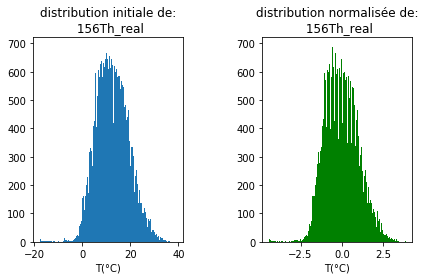

In [10]:
nomVariable=colsToScale[10]
print("voici les distrinutions initiale et normalisée de la station:"+nomVariable)

plt.subplot(1, 2, 1)
plt.hist(Xinput[colsToScale[10]], bins=200)
plt.xlabel('T(°C)')
plt.title("distribution initiale de:"+'\n '+nomVariable)

plt.subplot(1, 2, 2)
plt.hist(Xinput_scaled[colsToScale[10]], bins=200,color='green')
plt.xlabel('T(°C)')
plt.title("distribution normalisée de:"+'\n '+nomVariable)
plt.tight_layout(w_pad=5)
plt.show()

## II) Création de jeux d'apprentissage et de test

**Question** : A quoi servent les jeux d'entrainement, de validation, et de test ?

On se crée et on extrait 2 jeux de test de type différent, les données restantes constituant notre jeu d'entrainement-validation.
Ces 2 jeux de tests sont établis ainsi:
 - sélectionner une date de coupure (mai 2017) pour évaluer notre modèle, appris sur un historique, sur une période future.
 - sélection de quelques dates au hasard en été et en hiver avec la fonction _selectDatesRandomly_ pour établir la performance de notre modèle sur des journées thermosensibles.


In [11]:
def selectDatesRandomly(XwithDs, quarter, nDays, seed=10):
    joursQuarter = np.unique(XwithDs.loc[np.where(XwithDs.ds.dt.quarter == quarter)].ds.dt.date)
    np.random.seed(seed)
    joursSelected = np.random.choice(joursQuarter, replace=False, size=nDays)
    return joursSelected

In [12]:
# 1er jeu de test pour une séquence non vue, a partir du 1er mai 2017 par exemple
# 2eme jeu de test pour des jours dans l'historique du jeu d'entrainement, en particulier l'hiver et l'été pour capter l'effet de la température

def prepareDataSetEntrainementTest_TP2(Xinput, Yconso, dateDebut, dateRupture, nbJourlagRegresseur=0, njoursEte=10, njoursHiver=10):
    
    dateStart = Xinput.iloc[0]['ds']
    
    #les problèmes de données dues au lag sont maintenant gérés lorsque l'on charge les données
    #DateStartWithLag = dateStart + pd.Timedelta(str(nbJourlagRegresseur) + ' days')  # si un a un regresseur avec du lag, il faut prendre en compte ce lag et commencer l'entrainement a la date de debut des donnees+ce lag
   
    #On crée notre jeu de test "future" selon la date de rupture souhaitée
    XinputTest1 = Xinput[(Xinput.ds >= dateRupture)]
    XinputTrain = Xinput[(Xinput.ds < dateRupture) & (Xinput.ds >= dateDebut)] #& (Xinput.ds > DateStartWithLag) 
    YconsoTrain = Yconso[(Yconso.ds < dateRupture) & (Xinput.ds >= dateDebut)] #& (Yconso.ds > DateStartWithLag)
    YconsoTest1 = Yconso[(Yconso.ds >= dateRupture)]
    
    XinputTrain = XinputTrain.reset_index(drop=True)
    YconsoTrain = YconsoTrain.reset_index(drop=True)
    
    #On crée notre jeu de test "thermosensible"
    
    #On sélectionne des jours d'hiver et d'été
    joursHiverSelectionne = selectDatesRandomly(XinputTrain, 4, njoursHiver, seed=10)
    print("Les jours d'hiver du jeu de test sont : ")
    print(joursHiverSelectionne)
    
    joursEteSelectionne=selectDatesRandomly(XinputTrain, 2, njoursEte, seed=20)
    print("Les jours d'été du jeu de test sont : ")
    print(joursEteSelectionne)
    
    joursSelectionne = np.append(joursHiverSelectionne, joursEteSelectionne)
    
    XinputTest2 = XinputTrain[np.in1d(XinputTrain.ds.dt.date, joursSelectionne)]
    YconsoTest2 = YconsoTrain[np.in1d(YconsoTrain.ds.dt.date, joursSelectionne)]
    
    XinputTrain = XinputTrain[~np.in1d(XinputTrain.ds.dt.date, joursSelectionne)]
    YconsoTrain = YconsoTrain[~np.in1d(YconsoTrain.ds.dt.date, joursSelectionne)]
    
    XinputTrain = XinputTrain.reset_index(drop=True)
    YconsoTrain = YconsoTrain.reset_index(drop=True)
    XinputTest1 = XinputTest1.reset_index(drop=True)
    YconsoTest1 = YconsoTest1.reset_index(drop=True)
    XinputTest2 = XinputTest2.reset_index(drop=True)
    YconsoTest2 = YconsoTest2.reset_index(drop=True)
    
    XinputTrain = XinputTrain.drop(['ds'],axis=1)
    XinputTest1 = XinputTest1.drop(['ds'],axis=1)
    XinputTest2 = XinputTest2.drop(['ds'],axis=1)
    #indicesJoursEte=np.where(YconsoTrain.ds.dt.quarter==2)
    #joursHiver=
    #XinputTest2=Xinput[(Xinput.ds>=dateRupture)]
    
    #XinputTrain.reset_index(drop=True)
    #YconsoTrain.reset_index(drop=True)
    
    return XinputTrain, XinputTest1, XinputTest2, YconsoTrain, YconsoTest1, YconsoTest2

In [13]:
dateRupture = datetime.datetime(year=2017, month=5, day=1)  # début du challenge prevision de conso
dateDebut = datetime.datetime(year=2013, month=1, day=1)  # début du début de l'historique
nbJourlagRegresseur = 1

XinputTrain, XinputTest1, XinputTest2, YconsoTrain, YconsoTest1, YconsoTest2 = prepareDataSetEntrainementTest_TP2(Xinput, Y,dateDebut, dateRupture, nbJourlagRegresseur)

Les jours d'hiver du jeu de test sont : 
[datetime.date(2015, 10, 29) datetime.date(2016, 12, 30)
 datetime.date(2014, 10, 7) datetime.date(2015, 12, 5)
 datetime.date(2015, 10, 4) datetime.date(2013, 10, 7)
 datetime.date(2015, 12, 31) datetime.date(2014, 11, 2)
 datetime.date(2015, 11, 12) datetime.date(2013, 11, 13)]
Les jours d'été du jeu de test sont : 
[datetime.date(2013, 4, 11) datetime.date(2016, 6, 19)
 datetime.date(2014, 4, 27) datetime.date(2017, 4, 18)
 datetime.date(2013, 4, 18) datetime.date(2015, 5, 20)
 datetime.date(2014, 6, 21) datetime.date(2013, 5, 5)
 datetime.date(2016, 6, 30) datetime.date(2015, 5, 21)]


In [14]:
print('la taille de l échantillon XinputTrain est:' + str(XinputTrain.shape[0]))
print('la taille de l échantillon XinputTest1 est:' + str(XinputTest1.shape[0]))
print('la taille de l échantillon XinputTest2 est:' + str(XinputTest2.shape[0]))
print('la taille de l échantillon YconsoTrain est:' + str(YconsoTrain.shape[0]))
print('la taille de l échantillon YconsoTest1 est:' + str(YconsoTest1.shape[0]))
print('la taille de l échantillon YconsoTest2 est:' + str(YconsoTest2.shape[0]))
print('la proportion de data d entrainement est de:' + str(YconsoTrain.shape[0] / (YconsoTrain.shape[0] +YconsoTest2.shape[0]+ YconsoTest1.shape[0])))

la taille de l échantillon XinputTrain est:37387
la taille de l échantillon XinputTest1 est:1008
la taille de l échantillon XinputTest2 est:480
la taille de l échantillon YconsoTrain est:37387
la taille de l échantillon YconsoTest1 est:1008
la taille de l échantillon YconsoTest2 est:480
la proportion de data d entrainement est de:0.9617234726688103


In [15]:
XinputTrain.head()

,weekday,lag1D,lag1W,002Th_real,005Th_real,015Th_real,027Th_real,070Th_real,110Th_real,120Th_real,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,JoursFeries_24h_avant
0,1,66174.0,59679.0,9.6,9.7,9.9,9.6,9.6,9.6,9.3,...,0,0,0,0,0,0,0,0,0,0.0
1,1,61350.0,55354.0,9.6,9.5,9.9,9.6,9.5,9.2,9.0,...,0,0,0,0,0,0,0,0,0,0.0
2,1,60507.0,54324.0,9.7,9.5,9.8,9.5,9.2,9.2,8.8,...,0,0,0,0,0,0,0,0,0,0.0
3,1,58199.0,52066.0,9.8,9.4,9.7,9.3,8.9,9.0,8.8,...,0,0,0,0,0,0,0,0,0,0.0
4,1,55804.0,49684.0,9.6,9.5,9.8,9.2,8.9,9.3,8.7,...,0,0,0,0,0,0,0,0,0,0.0


In [16]:
print('Nombre de variables explicatives potentielles: ' + str(XinputTrain.shape[1]))
print('Nombre de variables explicatives potentielles: ' + str(XinputTest1.shape[1]))
print('Nombre de variables explicatives potentielles: ' + str(XinputTest2.shape[1]))

Nombre de variables explicatives potentielles: 204
Nombre de variables explicatives potentielles: 204
Nombre de variables explicatives potentielles: 204


# III) Création d'un modèle de réseau de neurones

Jusqu'ici, nous avons importé nos données. Nous les avons ensuite préparées pour les fournir au réseau de neurones (one-hot encoding, normalisation). Nous avons également créé nos jeux d'entrainement et de test.

Il est maintenant l'heure de se construire un réseau de neurones, de l'entrainer, et de lui faire faire des prédictions !

**Cette partie est générique et indépendante de notre problématique de prévision de consommation**

<img src="pictures/FirstNeuralNetwork.jpeg" width=700 height=60>

## Deux fonctions bien utiles

Nous allons commencer par implémenter deux fonctions que nous appellerons pour chacun des modèles que nous allons tester:
- Fonction 1: newKerasModel, pour instancier un modèle de réseau de neurone avant apprentissage
- Fonction 2: plotYourNeuralNet, pour visualiser un réseau de neurones

### Création d'une architecture de réseau de neurones

In [17]:
def newKerasModel(nInputs,nOutput=1, hLayers = None):
    """      
    arguments
        - nInputs : le nombre de features en entrée
        - nOutput : le nombre de sorties, variables à prédire
        - hLayers : un vecteur de couches cachées précisant la taille de chaque couchees
        
    returns
        - un objet de type Model 
    """
    model = Sequential()
    if(hLayers==None):
        hLayers = [nInputs, nInputs, nInputs, nInputs, nInputs, nInputs]
        
    nHiddenLayers=len(hLayers)
    
    model.add(Dense(hLayers[0], input_dim=nInputs, activation='relu'))
    for l in range(nHiddenLayers-1):
        model.add(Dense(hLayers[l+1], activation='relu'))

    # Pour une régression, la fonction d'activation finale est simplement la fonction identité
    model.add(Dense(nOutput, activation='linear'))  
    
    return model

### Inspection de l'architecture d'un reseau de neurones
On se créé un réseau avec un certains nombre de couches qui peuvent chacune avoir différentes dimensions. On peut ensuite inspecter les dimensions et le nombre de paramètres de ce réseau avec la méthode summary de Keras. 

In [18]:
#on se crée un réseau de neurones avec un certains nombre d'entrées et sorties
nInputs = 8 #un choix raisonnable pour visualiser ce modèle ensuite
nOutput=1
#hiddenLayers=[nInputs,round(nInputs/2),round(nInputs/2)]
hiddenLayers=[nInputs,nInputs,nInputs,nInputs,nInputs]
modelVide = newKerasModel(nInputs,nOutput,hLayers=hiddenLayers)
modelVide.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 369
Trainable params: 369
Non-trainable params: 0
______

Créons-nous maintenant une fonction pour dessiner ce réseau de neurones

In [19]:
%run auxiliairyMethodsTP2.py #on charge un fichier où sont définies nos fonctions auxilaires non détaillées dans ce TP
import pydot
from IPython.display import Image

def plotYourNeuralNet(model):
    layersModel=[model.input_shape[1]]
    for layer in model.layers:
        layersModel.append(layer.get_output_at(0).get_shape().as_list()[1])

    plotNeuralNet(layersModel)
    (graph,) =pydot.graph_from_dot_file('out.dot')
    
    fileNameImage='yourNeuralNet.png'
    graph.write_png(fileNameImage, prog='dot')
    img = Image(fileNameImage)
    display(img)

<Figure size 432x288 with 0 Axes>

Visualisons le reseau de neurone test créé précédemment

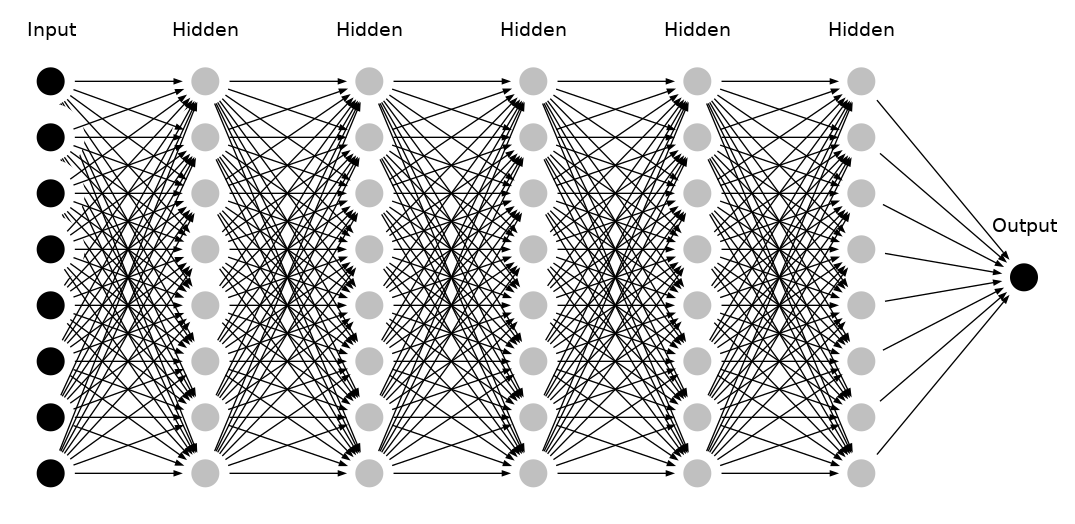

In [20]:
plotYourNeuralNet(modelVide)

ATTENTION: Pour des grandes tailles de reseau, cette visualisation n est pas adaptée et prendra beaucoup de temps a etre calcule! 
Le but vise etait ici davantage illustratif.

## IV) Un premier modèle de réseau de neurones: variables calendaires + lag conso

## Choix des variables explicatives

pour ce TP, nous avons un jeu d'entrée X contenant beaucoup de variables. Afin de commencer par un modèle simple, nous allons élaguer ce X pour réduire le nombre de features en entrée. Dans ce TP, nous allons donc lister les colonnes à retirer des datasets X initialisés ci-dessus.

Pour un cas d'étude réel, une approche pragmatique serait de commencer par se créer un premier X simple, de voir les performances du modèle, puis ensuite d'incorporer de plus en plus de features dans le X pour évaluer la progression des performances de nos modèles.
Toutefois en deep learning de premiers essais sont souvent réalisés en utilisant en entrée toute l'information disponible du fait de leur capacité à "digérer" la donnée, en se nourrissant d'informations redondantes.
D'un point de vue pédagogique, nous allons commencer avec la première approche.

Pour le premier réseau de neurones que nous allons entrainer, nous allons simplement garder les variables calendaires de Xinput.

In [21]:
# Initialement
XinputTrain.head()

,weekday,lag1D,lag1W,002Th_real,005Th_real,015Th_real,027Th_real,070Th_real,110Th_real,120Th_real,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,JoursFeries_24h_avant
0,1,66174.0,59679.0,9.6,9.7,9.9,9.6,9.6,9.6,9.3,...,0,0,0,0,0,0,0,0,0,0.0
1,1,61350.0,55354.0,9.6,9.5,9.9,9.6,9.5,9.2,9.0,...,0,0,0,0,0,0,0,0,0,0.0
2,1,60507.0,54324.0,9.7,9.5,9.8,9.5,9.2,9.2,8.8,...,0,0,0,0,0,0,0,0,0,0.0
3,1,58199.0,52066.0,9.8,9.4,9.7,9.3,8.9,9.0,8.8,...,0,0,0,0,0,0,0,0,0,0.0
4,1,55804.0,49684.0,9.6,9.5,9.8,9.2,8.9,9.3,8.7,...,0,0,0,0,0,0,0,0,0,0.0


On sélectionne les variables que l'on souhaite conserver en précisant simplement à quelle catégorie elles appartiennent.

In [22]:
#on précise le type de variable que l'on veut conserver par une abbréviation
colsType= ['lag1D','month','hour','dayOfWeek']
#any(ext in colsType for ext in extensionsToCheck)
colsToKeep=[s for s in Xinput.columns.get_values() if any(cs in s for cs in colsType)]

if('ds' in colsToKeep):#cette variable a été décomposée en mois, heure, jour et n'est plus une variable d'intérêt
    colsToKeep.remove('ds')


On restreint nos jeux d'entrainement et de tests à ces variables

In [23]:
X = XinputTrain[colsToKeep]
XTest1 = XinputTest1[colsToKeep]
XTest2 = XinputTest2[colsToKeep]

In [24]:
# Après élagage des variables
print(X.columns)
print(X.shape)
print(XTest1.shape)
print(XTest2.shape)

Index(['lag1D', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'dayOfWeek_0', 'dayOfWeek_1', 'dayOfWeek_2', 'dayOfWeek_3',
       'dayOfWeek_4', 'dayOfWeek_5', 'dayOfWeek_6', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')
(37387, 44)
(1008, 44)
(480, 44)


## Création du réseau de neurones et hyper-paramétrage
Un réseau de neurones profond est constuitué d'un certains nombre de couches, chacune portant un certain nombre de neurones. Ce sont 2 hyperparamètres que vous pouvez faire varier et qui vous permettront d'obtenir un apprentissage plus ou moins précis, en utilisant plus ou moins de puissance de calcul.

Le "learning rate" de l'optimiseur est également un hyperparamètre qui influencera la convergence et la vitesse de convergence de l'apprentissage, où l'on cherche à optimiser notre modèle pour minimiser l'erreur de prédiction. 

In [25]:
nInputs = X.shape[1]#nombre d'entrées du modèle
first_model = newKerasModel(nInputs)

In [26]:
first_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

# Tensorboard
c'est un utilitaire de tensorflow qui permet de visualiser en temps réel les courbes d'apprentissage des réseau de neurones et est donc utile pour arrêter l'apprentissage si les progrès sont faibles.

En particulier, vous pouvez vous intéresser à la courbe de l'erreur (loss) d'entrainement et de validation pour visualiser la progression de l'apprentissage et une tendance au surapprentissage en fin d'apprentissage.

<img src="pictures/CourbesTensorboard.png" width=1000 height=60>

**Pour ouvrir une fenêtre tensorboard, revenez sur la page d'accueil de Jupyter puis cliquez sur New (en haut à droite) et enfin sur Tensorboard**
Une fenêtre pop-up doit s'ouvrir. Si elle est bloquée, autorisez son ouverture.

In [27]:
# Conserver ses imports redondants ici car sinon des problèmes ont été constatés
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format("first_model_" +str(time())))

## Entrainement

La cellule suivante peut prendre un peu de temps à s'exécuter. On reconnait là la méthode fit commune à chaque modèle de machine learning pour entraîner son modèle.

In [28]:
# Fit the model

#en terme de paramètres:
#epoch: on précise le nombre d'epochs (le nombre de fois que l'on voit le jeu d'apprentissage en entier)
#batch size: le nombre d'exemples sur lequel on fait un "pas" d'apprentissage parmi tout le jeu
#validation_split: la proportion d'exemples que l'on conserve pour notre jeu de validation
#callbacks: pour appeler des utilitaires/fonctions externes pour récupérer des résultats
first_model.fit(X, YconsoTrain['y'], epochs=100, batch_size=100, validation_split=0.1, callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 33648 samples, validate on 3739 samples
Epoch 1/100
33648/33648 [==============================] - 1s 17us/step - loss: 164328901.2720 - mean_absolute_percentage_error: 11.9363 - val_loss: 21184923.7679 - val_mean_absolute_percentage_error: 5.3046
Epoch 2/100
33648/33648 [==============================] - 0s 12us/step - loss: 21975354.9320 - mean_absolute_percentage_error: 5.9693 - val_loss: 21495422.7481 - val_mean_absolute_percentage_error: 5.2700
Epoch 3/100
33648/33648 [==============================] - 0s 12us/step - loss: 21975055.3998 - mean_absolute_percentage_error: 5.9680 - val_loss: 21452977.7489 - val_mean_absolute_percentage_error: 5.3919
Epoch 4/100
33648/33648 [==============================] - 0s 12us/step - loss: 22059548.0392 - mean_absolute_percentage_error: 6.0021 - val_loss: 21165345.7606 - val_mean_absolute_percentage_error: 5.2381
Epoch 5/100
33648/33648 [==============================] - 0s 13us/step - los

33648/33648 [==============================] - 0s 14us/step - loss: 21248843.1082 - mean_absolute_percentage_error: 5.8577 - val_loss: 20238463.7200 - val_mean_absolute_percentage_error: 5.1530
Epoch 40/100
33648/33648 [==============================] - 0s 13us/step - loss: 21588518.8459 - mean_absolute_percentage_error: 5.9744 - val_loss: 20369431.2629 - val_mean_absolute_percentage_error: 5.1124
Epoch 41/100
33648/33648 [==============================] - 0s 11us/step - loss: 21020902.9985 - mean_absolute_percentage_error: 5.8049 - val_loss: 20079309.6598 - val_mean_absolute_percentage_error: 5.1460
Epoch 42/100
33648/33648 [==============================] - 0s 11us/step - loss: 21030624.8188 - mean_absolute_percentage_error: 5.8368 - val_loss: 19888911.5237 - val_mean_absolute_percentage_error: 5.0657
Epoch 43/100
33648/33648 [==============================] - 0s 11us/step - loss: 20972250.7952 - mean_absolute_percentage_error: 5.8500 - val_loss: 20258980.1030 - val_mean_absolute_per

Epoch 79/100
33648/33648 [==============================] - 0s 12us/step - loss: 10462263.9416 - mean_absolute_percentage_error: 4.4404 - val_loss: 10570064.4881 - val_mean_absolute_percentage_error: 4.0380
Epoch 80/100
33648/33648 [==============================] - 0s 12us/step - loss: 10257422.5321 - mean_absolute_percentage_error: 4.3910 - val_loss: 11483357.5485 - val_mean_absolute_percentage_error: 4.2174
Epoch 81/100
33648/33648 [==============================] - 0s 11us/step - loss: 10606042.0229 - mean_absolute_percentage_error: 4.4983 - val_loss: 10150542.1019 - val_mean_absolute_percentage_error: 3.9397
Epoch 82/100
33648/33648 [==============================] - 0s 11us/step - loss: 10345124.7260 - mean_absolute_percentage_error: 4.4164 - val_loss: 11514642.7384 - val_mean_absolute_percentage_error: 4.2277
Epoch 83/100
33648/33648 [==============================] - 0s 11us/step - loss: 10430050.6960 - mean_absolute_percentage_error: 4.4605 - val_loss: 10198846.5019 - val_mean

## Evaluation de la qualité du modèle

In [29]:
predictionsTrain = first_model.predict(X).reshape(-1)
predictionsTest1 = first_model.predict(XTest1).reshape(-1)
predictionsTest2 = first_model.predict(XTest2).reshape(-1)
print(predictionsTrain)

[63566.836 58870.848 58044.02  ... 43871.28  45220.92  48905.15 ]


l'erreur relative moyenne de test est de:5.5%
l'erreur relative max de test est de:27.3%
le rmse de test est de:3364.0

l'erreur relative moyenne de train est de:4.8%
l'erreur relative max de train est de:35.8%
le rmse de test est de:3419.0


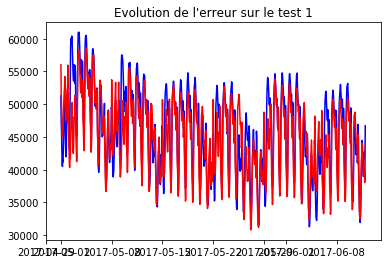

In [30]:
evaluation(YconsoTrain, YconsoTest1, predictionsTrain, predictionsTest1)
plt.plot(YconsoTest1['ds'], YconsoTest1['y'], 'b')
plt.plot(YconsoTest1['ds'], predictionsTest1, 'r')

plt.title("Evolution de l'erreur sur le test 1")
plt.show()

l'erreur relative moyenne de test est de:5.0%
l'erreur relative max de test est de:23.9%
le rmse de test est de:3641.0

l'erreur relative moyenne de train est de:4.8%
l'erreur relative max de train est de:35.8%
le rmse de test est de:3419.0


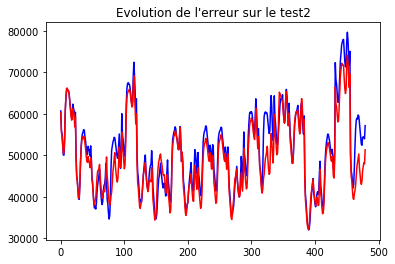

In [31]:
evaluation(YconsoTrain, YconsoTest2, predictionsTrain, predictionsTest2)

plt.plot(YconsoTest2['y'], 'b')
plt.plot(predictionsTest2, 'r')

plt.title("Evolution de l'erreur sur le test2")
plt.show()

L'erreur est ici comparable à celle des autres modèles en machine Learning (random forest, xgboost). Cela peut nous conforter dans le fait que notre réseau de neurones s'est créé de bonnes représentations pour ces variables calendaires. 

La différence en performance peut devenir plus flagrante lorsque l'on intègre des variables à une maille très granulaire (les pixels d'une images, la température dans toutes les villes de France) avec une forte interdépendance.

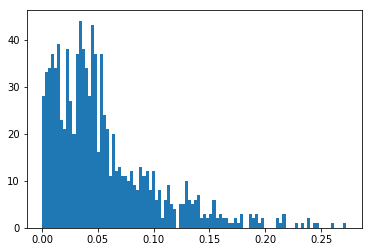

In [32]:
ErreursTest1, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YconsoTest1, predictionsTest1)
num_bins=100
plt.hist(ErreursTest1, num_bins)
plt.show()

Pour inspecter dynamiquement des visualisations, la librairie plotly se révèle très utile.
Ci-dessous vous pouvez identifier les jours et heures qui présentent les erreurs les plus importantes pour ensuite imaginer ce qui a pu pêcher.

In [33]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
init_notebook_mode(connected=True)
iplot([{"x": YconsoTest1['ds'], "y": ErreursTest1}])

## V) Un deuxième modèle : variables calendaires + lag conso normalisé!

Voyons a present l impact de la normalisation des variables d entree sur l apprentissage

## Choix des variables explicatives

pour ce TP, nous avons un jeu d'entrée X contenant beaucoup de variables. Afin de commencer par un modèle simple, nous allons élaguer ce X pour réduire le nombre de features en entrée. Dans ce TP, nous allons donc lister les colonnes à retirer des datasets X initialisés ci-dessus.

Pour un cas d'étude réel, une approche plus logique serait de commencer par se créer un premier X simple, de voir les performances du modèle, puis ensuite d'incorporer de plus en plus de features dans le X.

Pour le premier réseau de neurones que nous allons entrainer, nous allons simplement garder les variables calendaires de Xinput.

In [36]:
#To DO (1 ligne): creer vos jeux d entrainement et de test en utilisant les Xinput normalise et la methode prepareDataSetEntrainementTest_TP2

###########

Les jours d'hiver du jeu de test sont : 
[datetime.date(2015, 10, 29) datetime.date(2016, 12, 30)
 datetime.date(2014, 10, 7) datetime.date(2015, 12, 5)
 datetime.date(2015, 10, 4) datetime.date(2013, 10, 7)
 datetime.date(2015, 12, 31) datetime.date(2014, 11, 2)
 datetime.date(2015, 11, 12) datetime.date(2013, 11, 13)]
Les jours d'été du jeu de test sont : 
[datetime.date(2013, 4, 11) datetime.date(2016, 6, 19)
 datetime.date(2014, 4, 27) datetime.date(2017, 4, 18)
 datetime.date(2013, 4, 18) datetime.date(2015, 5, 20)
 datetime.date(2014, 6, 21) datetime.date(2013, 5, 5)
 datetime.date(2016, 6, 30) datetime.date(2015, 5, 21)]


In [37]:
# Initialement
XinputTrain.head()

,weekday,lag1D,lag1W,002Th_real,005Th_real,015Th_real,027Th_real,070Th_real,110Th_real,120Th_real,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,JoursFeries_24h_avant
0,1,0.946732,59679.0,-0.230388,-0.178131,-0.155003,-0.262759,-0.129697,-0.408908,-0.373427,...,0,0,0,0,0,0,0,0,0,0.0
1,1,0.546000,55354.0,-0.230388,-0.210971,-0.155003,-0.262759,-0.142481,-0.491017,-0.431943,...,0,0,0,0,0,0,0,0,0,0.0
2,1,0.475972,54324.0,-0.212743,-0.210971,-0.169714,-0.279890,-0.180834,-0.491017,-0.470954,...,0,0,0,0,0,0,0,0,0,0.0
3,1,0.284246,52066.0,-0.195098,-0.227392,-0.184425,-0.314152,-0.219186,-0.532071,-0.470954,...,0,0,0,0,0,0,0,0,0,0.0
4,1,0.085292,49684.0,-0.230388,-0.210971,-0.169714,-0.331284,-0.219186,-0.470490,-0.490459,...,0,0,0,0,0,0,0,0,0,0.0


On sélectionne les variables que l'on souhaite conserver en précisant simplement à quelle catégorie elles appartiennent.

In [38]:
#on précise le type de variable que l'on veut conserver par une abbréviation
colsType= ['lag1D','month','hour','dayOfWeek']
#any(ext in colsType for ext in extensionsToCheck)
colsToKeep=[s for s in Xinput.columns.get_values() if any(cs in s for cs in colsType)]

if('ds' in colsToKeep):#cette variable a été décomposée en mois, heure, jour et n'est plus une variable d'intérêt
    colsToKeep.remove('ds')


In [39]:
X = XinputTrain[colsToKeep]
XTest1 = XinputTest1[colsToKeep]
XTest2 = XinputTest2[colsToKeep]

In [40]:
# Après élagage
print(X.columns)
print(X.shape)
print(XTest1.shape)
print(XTest2.shape)

Index(['lag1D', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'dayOfWeek_0', 'dayOfWeek_1', 'dayOfWeek_2', 'dayOfWeek_3',
       'dayOfWeek_4', 'dayOfWeek_5', 'dayOfWeek_6', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')
(37387, 44)
(1008, 44)
(480, 44)


## Création du réseau de neurones et hyper-paramétrage
Un réseau de neurones profond est constuitué d'un certains nombre de couches, chacune portant un certain nombre de neurones. Ce sont 2 hyperparamètres que vous pouvez faire varier et qui vous permettront d'obtenir un apprentissage plus ou moins précis, en utilisant plus ou moins de puissance de calcul.

Le "learning rate" de l'optimiseur est également un hyperparamètre qui influencera la convergence et la vitesse de convergence de l'apprentissage, où l'on cherche à optimiser notre modèle pour minimser l'erreur de prédiction. 

In [41]:
nInputs = X.shape[1]
first_model_scaled = newKerasModel(nInputs)

In [42]:
first_model_scaled.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

# Tensorboard
c'est un utilitaire de tensorflow qui permet de visualiser en temps réel les courbes d'apprentissage des réseau de neurones et est donc utile pour arrêter l'apprentissage si les progrès sont faibles.

In [44]:
# Ajouter la ligne ci-dessous lève le problème
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format("first_model_scaled" +str(time())))

## Entrainement

La cellule suivante peut prendre un peu de temps à s'exécuter.

In [45]:
# Fit the model
first_model_scaled.fit(X, YconsoTrain['y'], epochs=100, batch_size=100, validation_split=0.1, callbacks=[tensorboard])

Train on 33648 samples, validate on 3739 samples
Epoch 1/100
33648/33648 [==============================] - 1s 18us/step - loss: 920638141.6480 - mean_absolute_percentage_error: 35.0899 - val_loss: 10580600.4988 - val_mean_absolute_percentage_error: 4.1409
Epoch 2/100
33648/33648 [==============================] - 0s 13us/step - loss: 8586420.5348 - mean_absolute_percentage_error: 4.0723 - val_loss: 10167175.3525 - val_mean_absolute_percentage_error: 4.0673
Epoch 3/100
33648/33648 [==============================] - 0s 13us/step - loss: 8232895.1519 - mean_absolute_percentage_error: 3.9408 - val_loss: 9891548.9071 - val_mean_absolute_percentage_error: 3.9828
Epoch 4/100
33648/33648 [==============================] - 0s 14us/step - loss: 7791336.7543 - mean_absolute_percentage_error: 3.7925 - val_loss: 9548988.7323 - val_mean_absolute_percentage_error: 3.9091
Epoch 5/100
33648/33648 [==============================] - 0s 13us/step - loss: 6982220.7421 - mean_absolute_percentage_error: 3.5

Epoch 41/100
33648/33648 [==============================] - 0s 13us/step - loss: 4083085.5506 - mean_absolute_percentage_error: 2.4510 - val_loss: 6047825.7905 - val_mean_absolute_percentage_error: 3.0596
Epoch 42/100
33648/33648 [==============================] - 0s 11us/step - loss: 4115697.8676 - mean_absolute_percentage_error: 2.4695 - val_loss: 5750940.2619 - val_mean_absolute_percentage_error: 2.9967
Epoch 43/100
33648/33648 [==============================] - 0s 11us/step - loss: 4102082.6319 - mean_absolute_percentage_error: 2.4755 - val_loss: 5858623.6785 - val_mean_absolute_percentage_error: 3.0127
Epoch 44/100
33648/33648 [==============================] - 0s 11us/step - loss: 4060793.7410 - mean_absolute_percentage_error: 2.4484 - val_loss: 5954041.1709 - val_mean_absolute_percentage_error: 3.0648
Epoch 45/100
33648/33648 [==============================] - 0s 13us/step - loss: 4059954.4091 - mean_absolute_percentage_error: 2.4607 - val_loss: 6311935.7435 - val_mean_absolute_

Epoch 81/100
33648/33648 [==============================] - 0s 14us/step - loss: 3963752.5710 - mean_absolute_percentage_error: 2.4302 - val_loss: 6211666.6874 - val_mean_absolute_percentage_error: 3.1616
Epoch 82/100
33648/33648 [==============================] - 1s 15us/step - loss: 3995643.4555 - mean_absolute_percentage_error: 2.4520 - val_loss: 6153458.2588 - val_mean_absolute_percentage_error: 3.1021
Epoch 83/100
33648/33648 [==============================] - 0s 14us/step - loss: 3930027.2670 - mean_absolute_percentage_error: 2.4041 - val_loss: 6085159.1976 - val_mean_absolute_percentage_error: 3.0969
Epoch 84/100
33648/33648 [==============================] - 0s 14us/step - loss: 3944816.0260 - mean_absolute_percentage_error: 2.4177 - val_loss: 6179236.8836 - val_mean_absolute_percentage_error: 3.1127
Epoch 85/100
33648/33648 [==============================] - 0s 14us/step - loss: 3977282.8190 - mean_absolute_percentage_error: 2.4353 - val_loss: 6079667.6410 - val_mean_absolute_

## Evaluation de la qualité du modèle

In [46]:
predictionsTrain = first_model_scaled.predict(X).reshape(-1)
predictionsTest1 = first_model_scaled.predict(XTest1).reshape(-1)
predictionsTest2 = first_model_scaled.predict(XTest2).reshape(-1)
print(predictionsTrain)

[66557.336 61746.99  61151.59  ... 48057.566 48398.395 51801.277]


l'erreur relative moyenne de test est de:3.5%
l'erreur relative max de test est de:33.1%
le rmse de test est de:2484.0

l'erreur relative moyenne de train est de:2.5%
l'erreur relative max de train est de:33.6%
le rmse de test est de:2019.0


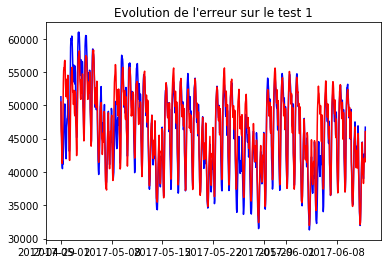

In [47]:
evaluation(YconsoTrain, YconsoTest1, predictionsTrain, predictionsTest1)
plt.plot(YconsoTest1['ds'], YconsoTest1['y'], 'b')
plt.plot(YconsoTest1['ds'], predictionsTest1, 'r')

plt.title("Evolution de l'erreur sur le test 1")
plt.show()

l'erreur relative moyenne de test est de:2.5%
l'erreur relative max de test est de:11.2%
le rmse de test est de:1776.0

l'erreur relative moyenne de train est de:2.5%
l'erreur relative max de train est de:33.6%
le rmse de test est de:2019.0


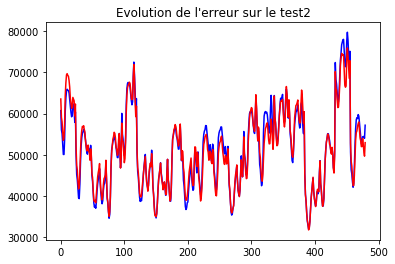

In [48]:
evaluation(YconsoTrain, YconsoTest2, predictionsTrain, predictionsTest2)

plt.plot(YconsoTest2['y'], 'b')
plt.plot(predictionsTest2, 'r')

plt.title("Evolution de l'erreur sur le test2")
plt.show()

L'erreur est ici comparable à celle de Prophet (5,8%) qui modèle nativement la notion de temps. Cela peut nous conforter dans le fait que notre réseau de neurones s'est créé de bonnes représentations pour ces variables calendaires

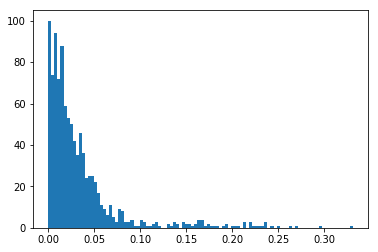

In [49]:
ErreursTest1, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YconsoTest1, predictionsTest1)
num_bins=100
plt.hist(ErreursTest1, num_bins)
plt.show()

In [50]:
init_notebook_mode(connected=True)
iplot([{"x": YconsoTest1['ds'], "y": ErreursTest1}])

### Discussion:
On observe qu'avec des données d'entrées normalisées l'apprentissage converge plus rapidement et même mieux !
<img src="pictures/CourbeApprentissageTensorboard.png" width=300 height=30>

# A vous de jouer, faites fonctionner vos neurones :

Il peut y avoir différents objectifs de performance selon le besoin. En général on cherche un compromis entre la précision du modèle et la puissance de calcul nécessaire pour entraîner et faire tourner ce modèle.

Nous décernerons 2 récompenses!

- Défi 1: le modèle le plus précis.
- Défi 2: le modèle le plus frugal moyennant une perte de précision.
Les critères sont encore à affiner ensemble!

<img src="pictures/we-need-you.png" width=500 height=60>



# entrainez et testez 2 nouveaux modèles avec de nouvelles variables choisies

N'hésitez pas à vous inspirer par le code ci-dessus ;-)
venez partager vos investigations sur cette google sheet : https://docs.google.com/spreadsheets/d/1oIx8jjzIh7Ugp3ZJMCOEwns6KCJxo4ua_jW5hIvjjFI/edit?usp=sharing

# Votre modèle 

## Rappel des variables explicatives à disposition

In [53]:
# Initialement
XinputTrain.columns.get_values()

array(['weekday', 'lag1D', 'lag1W', '002Th_real', '005Th_real',
       '015Th_real', '027Th_real', '070Th_real', '110Th_real',
       '120Th_real', '130Th_real', '145Th_real', '149Th_real',
       '156Th_real', '168Th_real', '180Th_real', '190Th_real',
       '222Th_real', '240Th_real', '255Th_real', '260Th_real',
       '280Th_real', '299Th_real', '434Th_real', '460Th_real',
       '481Th_real', '497Th_real', '510Th_real', '579Th_real',
       '588Th_real', '621Th_real', '630Th_real', '643Th_real',
       '645Th_real', '650Th_real', '675Th_real', '690Th_real',
       '747Th_real', 'FranceTh_real', '002Th_prev', '005Th_prev',
       '015Th_prev', '027Th_prev', '070Th_prev', '110Th_prev',
       '120Th_prev', '130Th_prev', '145Th_prev', '149Th_prev',
       '156Th_prev', '168Th_prev', '180Th_prev', '190Th_prev',
       '222Th_prev', '240Th_prev', '255Th_prev', '260Th_prev',
       '280Th_prev', '299Th_prev', '434Th_prev', '460Th_prev',
       '481Th_prev', '497Th_prev', '510Th_prev', '5

## Choix des variables explicatives

On sélectionne les variables que l'on souhaite conserver en précisant simplement à quelle catégorie elles appartiennent.

In [54]:
#########
#TO DO
#Préciser le type de variable que l'on veut conserver par une abbréviation
colsType=  [] #['lag1D','month','hour','dayOfWeek']

#Fin TO DO
#########

colsToKeep=[s for s in Xinput.columns.get_values() if any(cs in s for cs in colsType)]

if('ds' in colsToKeep):#cette variable a été décomposée en mois, heure, jour et n'est plus une variable d'intérêt
    colsToKeep.remove('ds')

In [55]:
X = XinputTrain[colsToKeep]
XTest1 = XinputTest1[colsToKeep]
XTest2 = XinputTest2[colsToKeep]

In [56]:
# Après élagage
print(X.columns)
print(X.shape)
print(XTest1.shape)
print(XTest2.shape)

Index(['lag1D', 'JoursFeries', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'dayOfWeek_0', 'dayOfWeek_1', 'dayOfWeek_2',
       'dayOfWeek_3', 'dayOfWeek_4', 'dayOfWeek_5', 'dayOfWeek_6', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'JoursFeries_24h_avant',
       'JoursFeries_J_1'],
      dtype='object')
(37387, 47)
(1008, 47)
(480, 47)


## Création du réseau de neurones, hyper-paramétrage

In [57]:
nInputs = X.shape[1]
votre_model_scaled_1 = newKerasModel(nInputs)

In [58]:
votre_model_scaled_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

# Tensorboard
c'est un utilitaire de tensorflow qui permet de visualiser en temps réel les courbes d'apprentissage des réseau de neurones et est donc utile pour arrêter l'apprentissage si les progrès sont faibles.

In [59]:
# Ajouter la ligne ci-dessous lève le problème
from keras.callbacks import TensorBoard
from time import time

#preciser le nom de votre modele avec les variables utilisees pour le visualiser dans tensorboard
nomModele=None#'votre_model_scaled_nomVariables'
tensorboard = TensorBoard(log_dir="logs/{}".format(nomModele +str(time())))

## Entrainement

La cellule suivante peut prendre un peu de temps à s'exécuter.

In [60]:
# Fit the model
votre_model_scaled_1.fit(X, YconsoTrain['y'], epochs=150, batch_size=100, validation_split=0.1, callbacks=[tensorboard])

Train on 33648 samples, validate on 3739 samples
Epoch 1/150
33648/33648 [==============================] - 1s 23us/step - loss: 867821862.6451 - mean_absolute_percentage_error: 33.4519 - val_loss: 10579757.4330 - val_mean_absolute_percentage_error: 4.0903
Epoch 2/150
33648/33648 [==============================] - 1s 15us/step - loss: 7645735.7124 - mean_absolute_percentage_error: 3.8902 - val_loss: 10537593.5432 - val_mean_absolute_percentage_error: 4.0592
Epoch 3/150
33648/33648 [==============================] - 1s 15us/step - loss: 7203614.4588 - mean_absolute_percentage_error: 3.7395 - val_loss: 10352193.0915 - val_mean_absolute_percentage_error: 4.0100
Epoch 4/150
33648/33648 [==============================] - 1s 16us/step - loss: 6887553.3235 - mean_absolute_percentage_error: 3.6252 - val_loss: 10434210.7210 - val_mean_absolute_percentage_error: 4.0106
Epoch 5/150
33648/33648 [==============================] - 1s 18us/step - loss: 6505646.8416 - mean_absolute_percentage_error: 3

Epoch 41/150
33648/33648 [==============================] - 0s 14us/step - loss: 2523642.8530 - mean_absolute_percentage_error: 2.0490 - val_loss: 5790057.8805 - val_mean_absolute_percentage_error: 2.9745
Epoch 42/150
33648/33648 [==============================] - 1s 15us/step - loss: 2496471.4584 - mean_absolute_percentage_error: 2.0329 - val_loss: 5487719.2333 - val_mean_absolute_percentage_error: 2.8988
Epoch 43/150
33648/33648 [==============================] - 0s 14us/step - loss: 2514279.1227 - mean_absolute_percentage_error: 2.0484 - val_loss: 5907606.8842 - val_mean_absolute_percentage_error: 3.0521
Epoch 44/150
33648/33648 [==============================] - 0s 15us/step - loss: 2486023.3866 - mean_absolute_percentage_error: 2.0248 - val_loss: 5578461.3593 - val_mean_absolute_percentage_error: 2.9659
Epoch 45/150
33648/33648 [==============================] - 0s 13us/step - loss: 2490493.6408 - mean_absolute_percentage_error: 2.0332 - val_loss: 5437530.5279 - val_mean_absolute_

Epoch 81/150
33648/33648 [==============================] - 0s 12us/step - loss: 2429294.9407 - mean_absolute_percentage_error: 2.0014 - val_loss: 6438162.4279 - val_mean_absolute_percentage_error: 3.1940
Epoch 82/150
33648/33648 [==============================] - 0s 12us/step - loss: 2406694.0224 - mean_absolute_percentage_error: 1.9910 - val_loss: 5501775.1714 - val_mean_absolute_percentage_error: 2.9277
Epoch 83/150
33648/33648 [==============================] - 0s 12us/step - loss: 2446987.1943 - mean_absolute_percentage_error: 2.0099 - val_loss: 5676876.4727 - val_mean_absolute_percentage_error: 2.9579
Epoch 84/150
33648/33648 [==============================] - 0s 12us/step - loss: 2421951.3571 - mean_absolute_percentage_error: 1.9976 - val_loss: 6055628.8371 - val_mean_absolute_percentage_error: 3.0330
Epoch 85/150
33648/33648 [==============================] - 0s 12us/step - loss: 2393725.3789 - mean_absolute_percentage_error: 1.9798 - val_loss: 5543891.7291 - val_mean_absolute_

Epoch 121/150
33648/33648 [==============================] - 0s 14us/step - loss: 2361796.2409 - mean_absolute_percentage_error: 1.9640 - val_loss: 5751629.6293 - val_mean_absolute_percentage_error: 2.9810
Epoch 122/150
33648/33648 [==============================] - 0s 14us/step - loss: 2365323.7644 - mean_absolute_percentage_error: 1.9685 - val_loss: 5691244.9197 - val_mean_absolute_percentage_error: 2.9758
Epoch 123/150
33648/33648 [==============================] - 0s 14us/step - loss: 2397479.1596 - mean_absolute_percentage_error: 1.9840 - val_loss: 5657915.2655 - val_mean_absolute_percentage_error: 2.9640
Epoch 124/150
33648/33648 [==============================] - 1s 15us/step - loss: 2354979.4467 - mean_absolute_percentage_error: 1.9523 - val_loss: 5909751.3389 - val_mean_absolute_percentage_error: 3.0382
Epoch 125/150
33648/33648 [==============================] - 1s 16us/step - loss: 2349112.2027 - mean_absolute_percentage_error: 1.9583 - val_loss: 5818026.3787 - val_mean_abso

## Evaluation de la qualité du modèle

In [ ]:
predictionsTrain = votre_model_scaled_1.predict(X).reshape(-1)
predictionsTest1 = votre_model_scaled_1.predict(XTest1).reshape(-1)
predictionsTest2 = votre_model_scaled_1.predict(XTest2).reshape(-1)
print(predictionsTrain)

In [ ]:
evaluation(YconsoTrain, YconsoTest1, predictionsTrain, predictionsTest1)
plt.plot(YconsoTest1['ds'], YconsoTest1['y'], 'b')
plt.plot(YconsoTest1['ds'], predictionsTest1, 'r')

plt.title("Evolution de l'erreur sur le test 1")
plt.show()

In [ ]:
evaluation(YconsoTrain, YconsoTest2, predictionsTrain, predictionsTest2)

plt.plot(YconsoTest2['y'], 'b')
plt.plot(predictionsTest2, 'r')

plt.title("Evolution de l'erreur sur le test2")
plt.show()

L'erreur est ici comparable à celle de Prophet (5,8%) qui modèle nativement la notion de temps. Cela peut nous conforter dans le fait que notre réseau de neurones s'est créé de bonnes représentations pour ces variables calendaires

In [ ]:
ErreursTest1, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(YconsoTest1, predictionsTest1)
num_bins=100
plt.hist(ErreursTest1, num_bins)
plt.show()

In [ ]:
init_notebook_mode(connected=True)
iplot([{"x": YconsoTest1['ds'], "y": ErreursTest1}])

# Pour aller encore plus loin

Le modèle ci-dessus peut être rendu encore plus performant par exemple en considérant des features comme "jour d'avant vacances", "jour d'après vacances"... 

Passer du temps à tuner les hyper-paramètres serait certainement bénéfique aussi.

De manière assez surprenante, élargir le réseau de neurones pour prédire les consommations régionales peut également améliorer la qualité de la prédiction de l'échelle nationale. C'est l'idée du multi-tasking.

On pourra également considérer en sortie du modèle non pas la prédiction pour juste 24 heures plus tard, mais plutôt pour une plage horaire  
[1 heure plus tard, ..., 24 heures plus tard]. Ceci permet de capter des dynamiques.


Des pistes:
insérer le lag Jours_Feries_J-1
voir si un intérêt à passer toutes les stations ou seulement la température France avec expertise sur importance des stations (en fait ça suffit avec les stations fournies!)


## Exemple d apprentissage avec differentes variables
Saurez-vous retrouver les variables utilisé pour ces differents apprentissages ?
A piocher parmi variables calendaires,lag de conso, tempreature, jours feries

<img src="pictures/ResultsApprentissages.png" width=500 height=50>